In [65]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from pmdarima import auto_arima


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [66]:
np.random.seed(1412)

In [67]:
price_quantity = np.random.randn(4100,2)

In [68]:
base_price_quantity = price_quantity[0]

In [69]:
initialDF = pd.DataFrame(price_quantity,columns=["price","quantity"])
initialDF.head()

,price,quantity
0,0.336519,0.506932
1,-0.098258,-0.705595
2,1.111341,-0.766724
3,1.079198,-2.110384
4,-0.651977,-1.507014


In [70]:
initialDF['cpi'] = pd.Series(initialDF["price"] * initialDF["quantity"]/base_price_quantity[0] * base_price_quantity[1])
initialDF.head()

,price,quantity,cpi
0,0.336519,0.506932,0.256980
1,-0.098258,-0.705595,0.104440
2,1.111341,-0.766724,-1.283591
3,1.079198,-2.110384,-3.430857
4,-0.651977,-1.507014,1.480095


In [71]:
cpi_index = pd.read_csv("data/CPIndex_Jan13-To-Jul19.csv")
cpi_index.head()

,Year,Month,State,Group,Sub Group,Description,Rural,Urban,Combined,Status,Unnamed: 10
0,2013,January,ALL India,1.0,1.1.01,Cereals and products,107.5,110.5,108.4,F,NaN
1,2013,February,ALL India,1.0,1.1.01,Cereals and products,109.2,112.9,110.4,F,NaN
2,2013,March,ALL India,1.0,1.1.01,Cereals and products,110.2,113.9,111.4,F,NaN
3,2013,April,ALL India,1.0,1.1.01,Cereals and products,110.2,114.6,111.6,F,NaN
4,2013,May,ALL India,1.0,1.1.01,Cereals and products,110.9,115.4,112.3,F,NaN


In [72]:
list(cpi_index)

['Year',
 'Month',
 'State',
 'Group',
 'Sub Group',
 'Description',
 'Rural',
 'Urban',
 'Combined',
 'Status',
 'Unnamed: 10']

In [73]:
fuel_cpi_index = cpi_index[cpi_index.Group==5.0]
fuel_cpi_index.head()

,Year,Month,State,Group,Sub Group,Description,Rural,Urban,Combined,Status,Unnamed: 10
1422,2013,January,ALL India,5.0,NaN,Fuel and light,105.5,105.4,105.5,F,NaN
1423,2013,February,ALL India,5.0,NaN,Fuel and light,106.2,105.7,106.0,F,NaN
1424,2013,March,ALL India,5.0,NaN,Fuel and light,106.1,106.0,106.1,F,NaN
1425,2013,April,ALL India,5.0,NaN,Fuel and light,106.5,106.4,106.5,F,NaN
1426,2013,May,ALL India,5.0,NaN,Fuel and light,107.5,107.2,107.4,F,NaN


In [74]:
combined_fuel_cpi = fuel_cpi_index[['Year', 'Month','Combined']]
months = {"January" : 1, "February" : 2, "March" : 3, "April" : 4, "May": 5, "June" : 6, "July" : 7, "August" : 8, "September" : 9, "October" : 10, "November" : 11, "December" : 12}
combined_fuel_cpi['Month'] = combined_fuel_cpi['Month'].map(lambda x: months[x])
combined_fuel_cpi['Timestamp'] = pd.to_datetime({'year' : combined_fuel_cpi['Year'], 'month' : combined_fuel_cpi['Month'], 'day':[1] * combined_fuel_cpi.shape[0]})
combined_fuel_cpi.head()

C:\Users\Lenovo\Anaconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,Month,Combined,Timestamp
1422,2013,1,105.5,2013-01-01
1423,2013,2,106.0,2013-02-01
1424,2013,3,106.1,2013-03-01
1425,2013,4,106.5,2013-04-01
1426,2013,5,107.4,2013-05-01


In [75]:
combined_fuel_cpi = combined_fuel_cpi.set_index("Timestamp")
combined_fuel_cpi.head()

,Year,Month,Combined
Timestamp,,,
2013-01-01,2013,1,105.5
2013-02-01,2013,2,106.0
2013-03-01,2013,3,106.1
2013-04-01,2013,4,106.5
2013-05-01,2013,5,107.4


In [76]:
combined_fuel_cpi = combined_fuel_cpi.drop(["Year", "Month"], axis = 1)
combined_fuel_cpi.head()

,Combined
Timestamp,
2013-01-01,105.5
2013-02-01,106.0
2013-03-01,106.1
2013-04-01,106.5
2013-05-01,107.4


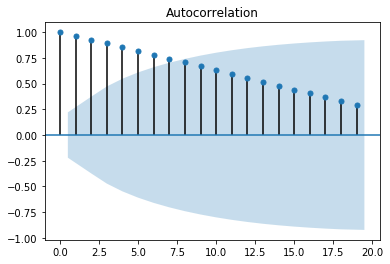

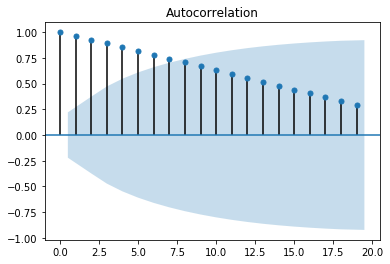

In [77]:
plot_acf(combined_fuel_cpi.values)

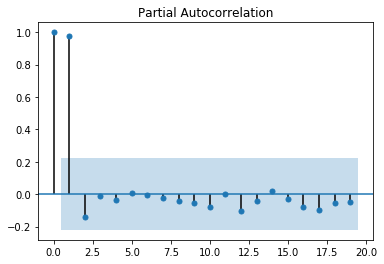

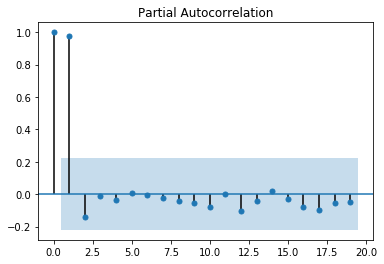

In [78]:
plot_pacf(combined_fuel_cpi.values)

In [79]:
total_dataset_size = len(combined_fuel_cpi.values)

In [80]:
arima_model = ARIMA(combined_fuel_cpi.values[:int(0.7 * total_dataset_size)], order = (8,1,0))

In [81]:
arima_results = arima_model.fit(disp=0)
arima_results.save("models/arima_model.pkl")

In [82]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -25.098
Method:                       css-mle   S.D. of innovations              0.381
Date:                Fri, 13 Sep 2019   AIC                             70.197
Time:                        12:47:48   BIC                             90.087
Sample:                             1   HQIC                            77.867
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4329      0.043     10.098      0.000       0.349       0.517
ar.L1.D.y      0.2871      0.132      2.168      0.036       0.028       0.547
ar.L2.D.y     -0.1776      0.143     -1.241      0.221      -0.458       0.103
ar.L3.D.y      0.0880      0.148      0.596      0.554      -0.201       0.377
ar.L4.D.y     -0.0490      0.151     -0.324      0.748      -0.345       0.248
ar.L5.D.y     -0.0433      0.147     -0.295      0.769      -0.331       0.244
ar.L6.D.y     -0.2108      0.153     -1.374      0.176      -0.511       0.090
ar.L7.D.y      0.0916      0.158      0.580      0.565      -0.218       0.401
ar.L8.D.y     -0.2781      0.165     -1.687      0.099      -0.601       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0335           -0.5361j            1.1642           -0.4238
AR.2           -1.0335           +0.5361j            1.1642            0.4238
AR.3            1.0072           -0.4718j            1.1123           -0.0697
AR.4            1.0072           +0.4718j            1.1123            0.0697
AR.5           -0.2994           -1.1282j            1.1673           -0.2913
AR.6           -0.2994           +1.1282j            1.1673            0.2913
AR.7            0.4903           -1.1546j            1.2544           -0.1861
AR.8            0.4903           +1.1546j            1.2544            0.1861
-----------------------------------------------------------------------------
"""

In [83]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [84]:
normalized_combined_fuel_cpi = normalize(combined_fuel_cpi)
normalized_combined_fuel_cpi.head()

,Combined
Timestamp,
2013-01-01,0.000000
2013-02-01,0.014006
2013-03-01,0.016807
2013-04-01,0.028011
2013-05-01,0.053221


In [85]:
normalized_arima_model = ARIMA(normalized_combined_fuel_cpi.values[:int(0.7 * total_dataset_size)], order = (2, 1, 0))
normalized_arima_model_results = normalized_arima_model.fit()
normalized_arima_model_results.save("models/normalized_arima_model.pkl")

In [86]:
normalized_arima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 165.779
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 13 Sep 2019   AIC                           -323.558
Time:                        12:47:56   BIC                           -315.602
Sample:                             1   HQIC                          -320.489
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.002      7.146      0.000       0.009       0.016
ar.L1.D.y      0.3163      0.135      2.348      0.023       0.052       0.580
ar.L2.D.y     -0.1866      0.142     -1.313      0.195      -0.465       0.092
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8474           -2.1540j            2.3147           -0.1903
AR.2            0.8474           +2.1540j            2.3147            0.1903
-----------------------------------------------------------------------------
"""

In [108]:
print(combined_fuel_cpi.values[int(0.7 * total_dataset_size):])
forecasted_fuel_cpi = arima_results.forecast(total_dataset_size - int(0.7 * total_dataset_size))[0]
forecasted_fuel_cpi_df = pd.DataFrame(forecasted_fuel_cpi, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['predicted_cpi'])
forecasted_fuel_cpi_df.head()
print(combined_fuel_cpi.values)
a=np.array(combined_fuel_cpi.values.tolist()[int(0.7 * total_dataset_size):]).flatten()
b=np.array(forecasted_fuel_cpi)

a = (a - np.mean(a)) / (np.std(a) )
b = (b - np.mean(b)) / (np.std(b))
print(len(a),len(b))
print(a,"\n",b)
c = np.correlate(a, b, 'same')
c= pd.DataFrame(c, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['predicted_cpi'])*[forecasted_fuel_cpi]



[[129.8]
 [131. ]
 [132.2]
 [135.3]
 [136.6]
 [136.6]
 [136.7]
 [136.5]
 [136.5]
 [136.9]
 [138.1]
 [139.7]
 [139.6]
 [139.1]
 [139.8]
 [139.2]
 [139.1]
 [139.5]
 [139.4]
 [139.7]
 [140. ]
 [140.3]
 [141.2]
 [139.2]]
[[105.5]
 [106. ]
 [106.1]
 [106.5]
 [107.4]
 [108.3]
 [109.2]
 [109.7]
 [110.5]
 [110.9]
 [111.6]
 [111.9]
 [112.2]
 [112.4]
 [112.5]
 [112.5]
 [112.5]
 [113.2]
 [113.9]
 [114. ]
 [114.3]
 [114.7]
 [115.5]
 [115.7]
 [116.5]
 [117.7]
 [118.3]
 [118.7]
 [119.2]
 [119.8]
 [120.1]
 [120.6]
 [120.4]
 [120.8]
 [121.6]
 [122. ]
 [122.7]
 [123.1]
 [122.4]
 [122.3]
 [122.7]
 [123.3]
 [123.4]
 [123.6]
 [124.1]
 [124.3]
 [125. ]
 [126.6]
 [126.8]
 [127.9]
 [129.1]
 [129.8]
 [129.4]
 [128.8]
 [129.4]
 [129.8]
 [131. ]
 [132.2]
 [135.3]
 [136.6]
 [136.6]
 [136.7]
 [136.5]
 [136.5]
 [136.9]
 [138.1]
 [139.7]
 [139.6]
 [139.1]
 [139.8]
 [139.2]
 [139.1]
 [139.5]
 [139.4]
 [139.7]
 [140. ]
 [140.3]
 [141.2]
 [139.2]]
24 24
[-2.66344515 -2.25280693 -1.8421687  -0.78135329 -0.33649521 -0.3

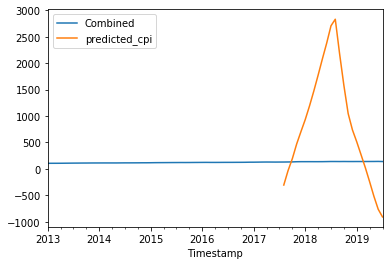

In [109]:
actual_forecasted_df = combined_fuel_cpi.join(c)#forecasted_fuel_cpi_df)
actual_forecasted_df.plot()

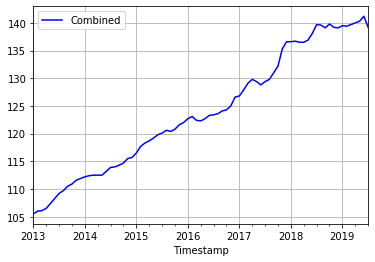

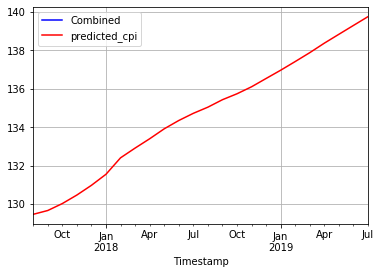

In [88]:
ax1 = combined_fuel_cpi.plot(color='blue', grid=True, label='Actual')
ax2 = forecasted_fuel_cpi_df.plot(color='red', grid = True, label = 'Forecasted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()


In [112]:
print(normalized_combined_fuel_cpi.values[int(0.7 * total_dataset_size):])
normalized_arima_model_results.forecast(total_dataset_size - int(0.7 * total_dataset_size))[0]

[[0.61363636]
 [0.64393939]
 [0.67424242]
 [0.75252525]
 [0.78535354]
 [0.78535354]
 [0.78787879]
 [0.78282828]
 [0.78282828]
 [0.79292929]
 [0.82323232]
 [0.86363636]
 [0.89393939]
 [0.92929293]
 [0.95959596]
 [1.        ]
 [0.93939394]
 [0.85858586]
 [0.83080808]
 [0.86363636]
 [0.87121212]
 [0.87878788]
 [0.90151515]
 [0.8510101 ]]


array([0.61849982, 0.62894264, 0.64037427, 0.65158966, 0.66285234,
       0.67410467, 0.68535927, 0.69661337, 0.70786758, 0.71912177,
       0.73037596, 0.74163016, 0.75288435, 0.76413854, 0.77539273,
       0.78664692, 0.79790112, 0.80915531, 0.8204095 , 0.83166369,
       0.84291788, 0.85417208, 0.86542627, 0.87668046])

In [113]:
initialDF.head()

,price,quantity,cpi
0,2.336519,2.506932,6.284707
1,1.901742,1.294405,2.641161
2,3.111341,1.233276,4.117003
3,3.079198,-0.110384,-0.364684
4,1.348023,0.492986,0.713025


In [131]:
pd.date_range(end='2019-09-01',periods = 4100, freq = 'MS')

DatetimeIndex(['1678-02-01', '1678-03-01', '1678-04-01', '1678-05-01',
               '1678-06-01', '1678-07-01', '1678-08-01', '1678-09-01',
               '1678-10-01', '1678-11-01',
               ...
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', length=4100, freq='MS')

In [155]:
initalDF_total_size = initialDF.shape[0]

In [156]:
initialDF = initialDF.set_index(pd.date_range(end='2019-09-01', periods = initalDF_total_size, freq = 'MS'))

In [157]:
initialDF = initialDF.drop(['price','quantity'], axis = 1)
initialDF.head()

,cpi
1678-02-01,0.152705
1678-03-01,0.411970
1678-04-01,-0.000222
1678-05-01,0.027525
1678-06-01,0.192640


In [175]:
initialDF_arima_model = ARIMA(initialDF.values[:int(0.7 * initalDF_total_size)], order = (1, 1, 1))
initialDF_arima_model_results = initialDF_arima_model.fit(disp = 0)
initialDF_arima_model_results.save("models/initialDF_arima_model.pkl")

In [176]:
initialDF_arima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2869
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -818.922
Method:                       css-mle   S.D. of innovations              0.321
Date:                Tue, 10 Sep 2019   AIC                           1645.844
Time:                        18:14:41   BIC                           1669.691
Sample:                             1   HQIC                          1654.441
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.176e-05   7.02e-06      1.675      0.094      -2e-06    2.55e-05
ar.L1.D.y     -0.0340      0.019     -1.822      0.069      -0.071       0.003
ma.L1.D.y     -0.9999      0.001  -1009.069      0.000      -1.002      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -29.4083           +0.0000j           29.4083            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [164]:
print(initialDF.values[int(0.7 * initalDF_total_size): int(0.7 * initalDF_total_size) + 10])
print(initialDF_arima_model_results.forecast(10)[0])

[[ 0.1403513 ]
 [ 0.07503152]
 [ 0.24127928]
 [ 0.01450218]
 [ 0.07665108]
 [-0.05240045]
 [ 0.01934591]
 [-0.46488274]
 [-0.42913861]
 [-0.02519659]]
[0.02687004 0.02181415 0.02199823 0.02200413 0.02201608 0.02202783
 0.02203959 0.02205134 0.0220631  0.02207486]


In [45]:
stepwise_fit = auto_arima(combined_fuel_cpi, start_p = 1, start_q = 1, max_p = 5, max_q = 3, m = 12, start_P=0, seasonal = True, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=176.071, BIC=187.020, Fit time=1.719 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=199.556, BIC=203.935, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=179.976, BIC=188.735, Fit time=1.429 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=175.263, BIC=184.022, Fit time=1.394 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=176.362, BIC=187.311, Fit time=5.482 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=180.884, BIC=187.453, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=191.651, BIC=198.220, Fit time=1.202 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=175.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   79
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -83.632
Date:                            Fri, 13 Sep 2019   AIC                            175.263
Time:                                    12:16:20   BIC                            184.022
Sample:                                         0   HQIC                           178.724
                                             - 79                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0625      0.090     -0.695      0.487      -0.239       0.114
ma.L1          0.5485      0.110      4.982      0.000       0.333       0.764
ma.S.L12      -0.6187      0.257     -2.407      0.016      -1.122      -0.115
sigma2         0.6728      0.089      7.525      0.000       0.498       0.848
===================================================================================
Ljung-Box (Q):                       43.04   Jarque-Bera (JB):                66.00
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              11.76   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
X = combined_fuel_cpi.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    sm_model = ARIMA(history,order=(8,1,0))
    sm_model_fit = sm_model.fit(disp=0)
    print(sm_model_fit.summary())
    output = sm_model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('prediction=%f,expected=%f' %(yhat,obs))
# error = mean_squared_error(test,predictions)
print('Test MSE: %.3f' %error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -25.098
Method:                       css-mle   S.D. of innovations              0.381
Date:                Fri, 13 Sep 2019   AIC                             70.197
Time:                        12:40:47   BIC                             90.087
Sample:                             1   HQIC                            77.867
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4329      0.043     10.098      0.000       0.349       0.517
ar.L1.D.y      0.2871      0.132      2.168      0.036       0.028       0.547
ar.L2.D.y     -0.1776      0.143     -1.241      0.2

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   58
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -39.841
Method:                       css-mle   S.D. of innovations              0.475
Date:                Fri, 13 Sep 2019   AIC                             99.681
Time:                        12:41:05   BIC                            120.286
Sample:                             1   HQIC                           107.707
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5041      0.071      7.086      0.000       0.365       0.644
ar.L1.D.y      0.3910      0.157      2.497      0.016       0.084       0.698
ar.L2.D.y      0.0165      0.163      0.102      0.9

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   62
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -40.962
Method:                       css-mle   S.D. of innovations              0.462
Date:                Fri, 13 Sep 2019   AIC                            101.925
Time:                        12:41:24   BIC                            123.196
Sample:                             1   HQIC                           110.276
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4930      0.059      8.380      0.000       0.378       0.608
ar.L1.D.y      0.3678      0.126      2.908      0.005       0.120       0.616
ar.L2.D.y     -0.0558      0.131     -0.426      0.6

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   66
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -42.524
Method:                       css-mle   S.D. of innovations              0.456
Date:                Fri, 13 Sep 2019   AIC                            105.047
Time:                        12:41:41   BIC                            126.944
Sample:                             1   HQIC                           113.700
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5193      0.068      7.684      0.000       0.387       0.652
ar.L1.D.y      0.3737      0.123      3.044      0.004       0.133       0.614
ar.L2.D.y     -0.0506      0.127     -0.397      0.6

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   70
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -47.371
Method:                       css-mle   S.D. of innovations              0.472
Date:                Fri, 13 Sep 2019   AIC                            114.742
Time:                        12:41:59   BIC                            137.227
Sample:                             1   HQIC                           123.673
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5680      0.087      6.522      0.000       0.397       0.739
ar.L1.D.y      0.4475      0.124      3.618      0.001       0.205       0.690
ar.L2.D.y     -0.0065      0.129     -0.050      0.9

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   74
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -69.148
Method:                       css-mle   S.D. of innovations              0.606
Date:                Fri, 13 Sep 2019   AIC                            158.297
Time:                        12:42:15   BIC                            181.337
Sample:                             1   HQIC                           167.488
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5019      0.055      9.185      0.000       0.395       0.609
ar.L1.D.y      0.5130      0.117      4.380      0.000       0.283       0.743
ar.L2.D.y     -0.2775      0.129     -2.151      0.0

NameError: name 'mean_squared_error' is not defined

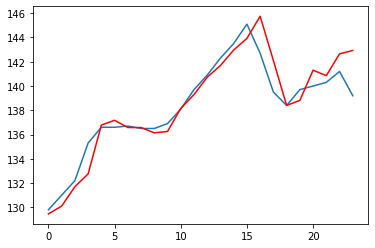

In [110]:
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

In [116]:
print(X.flatten())

[105.5 106.  106.1 106.5 107.4 108.3 109.2 109.7 110.5 110.9 111.6 111.9
 112.2 112.4 112.5 112.5 112.5 113.2 113.9 114.  114.3 114.7 115.5 115.7
 116.5 117.7 118.3 118.7 119.2 119.8 120.1 120.6 120.4 120.8 121.6 122.
 122.7 123.1 122.4 122.3 122.7 123.3 123.4 123.6 124.1 124.3 125.  126.6
 126.8 127.9 129.1 129.8 129.4 128.8 129.4 129.8 131.  132.2 135.3 136.6
 136.6 136.7 136.5 136.5 136.9 138.1 139.7 140.9 142.3 143.5 145.1 142.7
 139.5 138.4 139.7 140.  140.3 141.2 139.2]


In [115]:
np.array(predictions).flatten()

array([129.45809105, 130.10434841, 131.69835331, 132.75708004,
       136.78161568, 137.1757672 , 136.57877863, 136.58011319,
       136.14127745, 136.25314665, 138.15065128, 139.29279728,
       140.72929359, 141.69109012, 142.96817539, 143.92684655,
       145.75087096, 142.09819529, 138.40226895, 138.81392328,
       141.30510012, 140.85413363, 142.65377212, 142.92884259])

In [134]:
actuals = pd.DataFrame(test, index = combined_fuel_cpi[int(0.7 * total_dataset_size):len(X)].index, columns=['Combined'])
actuals.head()

,Combined
Timestamp,
2017-08-01,129.8
2017-09-01,131.0
2017-10-01,132.2
2017-11-01,135.3
2017-12-01,136.6


In [120]:
forecasts = pd.DataFrame(predictions, index = combined_fuel_cpi[int(0.7 * total_dataset_size):len(X)].index, columns=['predicted_cpi'])
forecasts.head()

,predicted_cpi
Timestamp,
2017-08-01,129.458091
2017-09-01,130.104348
2017-10-01,131.698353
2017-11-01,132.757080
2017-12-01,136.781616


In [135]:
final_df = actuals.join(forecasts)
final_df.head()

,Combined,predicted_cpi
Timestamp,,
2017-08-01,129.8,129.458091
2017-09-01,131.0,130.104348
2017-10-01,132.2,131.698353
2017-11-01,135.3,132.757080
2017-12-01,136.6,136.781616


In [136]:
k=final_df

print([dict(zip(['month','values','predicted'],[str(index)[:10],i['Combined'],i['predicted_cpi']])) for index,i in k.iterrows()])

[{'month': '2017-08-01', 'values': 129.8, 'predicted': 129.45809104557068}, {'month': '2017-09-01', 'values': 131.0, 'predicted': 130.10434840701507}, {'month': '2017-10-01', 'values': 132.2, 'predicted': 131.69835331432338}, {'month': '2017-11-01', 'values': 135.3, 'predicted': 132.7570800400743}, {'month': '2017-12-01', 'values': 136.6, 'predicted': 136.78161568245736}, {'month': '2018-01-01', 'values': 136.6, 'predicted': 137.17576719906998}, {'month': '2018-02-01', 'values': 136.7, 'predicted': 136.57877863161767}, {'month': '2018-03-01', 'values': 136.5, 'predicted': 136.58011318951367}, {'month': '2018-04-01', 'values': 136.5, 'predicted': 136.14127745386108}, {'month': '2018-05-01', 'values': 136.9, 'predicted': 136.2531466498307}, {'month': '2018-06-01', 'values': 138.1, 'predicted': 138.15065128154185}, {'month': '2018-07-01', 'values': 139.7, 'predicted': 139.29279728178417}, {'month': '2018-08-01', 'values': 140.9, 'predicted': 140.72929358881444}, {'month': '2018-09-01', 'v

In [129]:

for index, row in final_df.iterrows():
    #print (index[:10])
    print(row)
    break

Combined         129.800000
predicted_cpi    129.458091
Name: 2017-08-01 00:00:00, dtype: float64
